In [1]:
from scipy import interpolate

from scipy.interpolate import interp2d

from scipy.spatial import Delaunay

from skimage.draw import polygon

from moviepy.editor import ImageSequenceClip

import numpy as np

import skimage as sk
import skimage.io as skio



from PIL import Image as im

import glob


import math

import cv2

import PyQt5

In [2]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)

In [6]:
roof_fnames = ['data\\roof1.jpg', 'data\\roof2.jpg', 'data\\roof3.jpg']
roofpics = [sk.img_as_float(skio.imread(fname)) for fname in roof_fnames]

Getting points:

To avoid confusion, all the points will be stored in dictionaries.

So the lobby points will be in the lobby_points dictionary. The keys will be like:

{'1to2': points on image one that are meant to match with image 2,

'2to1': points on image two that are meant to match with image 1, etc.}

In [31]:
%matplotlib qt
plt.imshow(roofpics[1])
pts = np.asarray(plt.ginput(-1, timeout=60))
pts

array([[ 691.97859147,  368.62674501],
       [  89.07809688,  597.31313951],
       [ 474.29849403,  582.63807676],
       [ 515.87783849,  614.43404605],
       [  76.84887792,  821.10784642],
       [ 721.32871697,  750.17837647],
       [ 721.32871697,  750.17837647],
       [ 377.68766427, 1042.45670955],
       [ 608.81990256, 1080.36728832]])

From running the above repeatedly:

In [35]:
roof_points = {
    '0to1': np.array([[ 945.12342389,  576.52346728],
       [1280.20402331,  559.40256074],
       [1323.00628966,  592.42145192],
       [ 936.56297062,  763.63051733],
       [1578.59696587,  751.40129837],
       [1186.03903734, 1006.99197458],
       [1431.84633838, 1099.93403865]]),
    '1to0': np.array([[  89.07809688,  597.31313951],
       [ 474.29849403,  582.63807676],
       [ 515.87783849,  614.43404605],
       [  76.84887792,  821.10784642],
       [ 721.32871697,  750.17837647],
       [ 377.68766427, 1042.45670955],
       [ 608.81990256, 1080.36728832]]),
    '1to2': np.array([[1139.56800531,  608.31943657],
       [1365.80855602,  593.64437382],
       [1447.74432303,  600.98190519],
       [ 968.3589399 , 1131.73000794],
       [1016.05289384,  848.01212813],
       [1253.29974161,  810.10154936],
       [1349.91057137,  929.94789514]]),
    '2to1': np.array([[ 325.10202275,  604.65067088],
       [ 548.89672967,  587.52976434],
       [ 617.38035583,  594.86729572],
       [ 124.54283185, 1200.2136341 ],
       [ 182.02016095,  872.47056605],
       [ 446.17129043,  802.76401799],
       [ 535.44458882,  903.04361344]]),
}

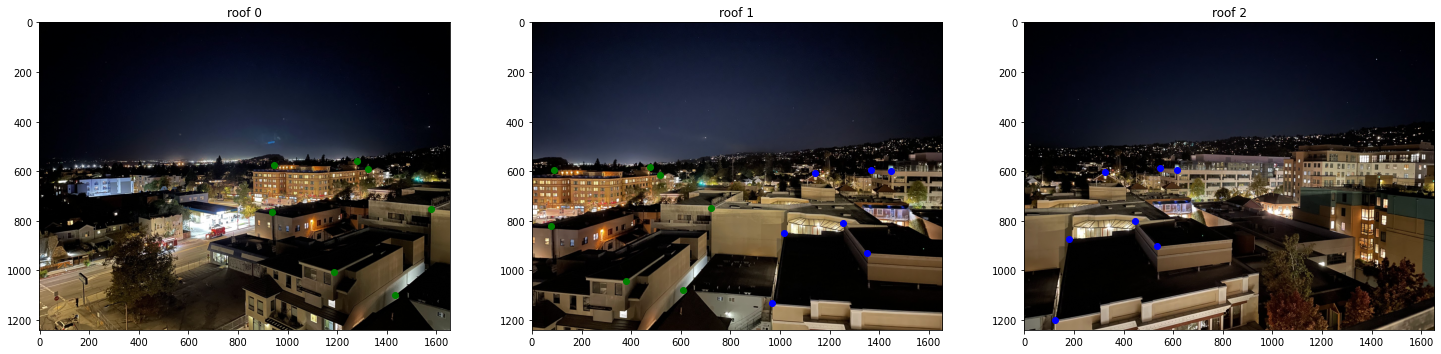

In [58]:
%matplotlib inline
fig = plt.figure(figsize=(25, 10))
subplots = fig.subplots(1, 3)
ax0, ax1, ax2 = subplots[0], subplots[1], subplots[2]

ax0.set_title('roof 0')
ax1.set_title('roof 1')
ax2.set_title('roof 2')

ax0.imshow(roofpics[0])
ax1.imshow(roofpics[1])
ax2.imshow(roofpics[2])

ax0.scatter(*zip(*roof_points['0to1']), color = 'green')
ax1.scatter(*zip(*roof_points['1to0']), color = 'green')
ax1.scatter(*zip(*roof_points['1to2']), color = 'blue')
ax2.scatter(*zip(*roof_points['2to1']), color = 'blue')

## Perspective transformation from $n$ points?

$$\begin{bmatrix}
wx'\\ 
wy'\\ 
w
\end{bmatrix} = 
\begin{bmatrix}
a &b  &c \\ 
d &e  &f \\ 
g &h  &1
\end{bmatrix}
\begin{bmatrix}
x\\ 
y\\ 
1
\end{bmatrix}$$

To phrase this into equations:

$$x'w = ax + by + c$$
$$y'w = dx + ey + f$$
$$w = gx + hy + 1$$

However, we need to remove $w$ from this set of equations, since we do not know the value of $w$.

So:

$$w - (gx + hy) = 1$$
$$w - 1 = (gx + hy)$$

$$x' = x'w - x'(w-1)$$
$$x' = x'w - x'(gx + hy)$$
$$x' = ax + by + c - gx'x - hx'y$$

By the same logic, 
$$y' = dx + ey + f - gxy'x - hy'y$$

This allows us to use the following system of equations:

$$
\begin{bmatrix}
x'_0\\
y'_0\\
x'_1\\
y'_1\\ 
\vdots\\
x'_n\\
y'_n
\end{bmatrix}
=
\begin{bmatrix}
x_0 & y_0 & 1 & 0 & 0 & 0 & -x'_0x_0 & -x'_0y_0\\
0 & 0 & 0 & x_0 & y_0 & 1 & -y'_0x_0 & -y'_0y_0\\
x_1 & y_1 & 1 & 0 & 0 & 0 & -x'_1x_1 & -x'_1y_1\\
0 & 0 & 0 & x_1 & y_1 & 1 & -y'_1x_1 & -y'_1y_1\\
&&&&\vdots&&& \\
x_n & y_n & 1 & 0 & 0 & 0 & -x'_nx_n & -x'_ny_n\\
0 & 0 & 0 & x_n & y_n & 1 & -y'_nx_n & -y'_ny_n
\end{bmatrix}
\begin{bmatrix}
a\\
b\\
c\\
d\\
e\\
f\\
g\\
h
\end{bmatrix}
$$

In [17]:
"""
get a affine transform matrix from a triangle
params:
1. simplex - the 3 indices connected by the triangle
2. pts_1 - original point coordinates
3. pts_2 - the new points

returns:
a matrix : ) 
"""
def compute_H(src_pts, dst_pts):
    
    def get_A_components(idx):
        x, y = src_pts[idx]
        xp,yp = dst_pts[idx]
        
        list1 = [x, y, 1, 0, 0, 0, -1*xp*x, -1*xp*y]
        list2 = [0, 0, 0, x, y, 1, -1*yp*x, -1*yp*y]
        return np.array([list1, list2])

    def get_b_components(idx):
        xp, yp = dst_pts[idx]
        return np.array([xp, yp]).reshape((2,1))
    
    assert len(src_pts) == len(dst_pts)
    n = len(src_pts)
    
    A = np.vstack([get_A_components(idx) for idx in range(n)])
    b = np.vstack([get_b_components(idx) for idx in range(n)])
    
    h = np.linalg.lstsq(A, b)[0].flatten()
#     h = np.linalg.solve(A, b).flatten()
    a,b,c,d,e,f,g,h = h
    
    H = np.array([[a,b,c],[d,e,f],[g,h,1]])
    
    return H

In [18]:
def normalize(arr):
    ws = arr[:,2].reshape(len(arr), 1)
    return (arr/ws)[:,:2]

In [19]:
def new_canvas_ranges(orig_img, H):
    h, w = orig_img.shape[:2]
    topleft_o = np.array([0,0,1])
    topright_o = np.array([w,0,1])
    botleft_o = np.array([0,h,1])
    botright_o = np.array([w,h,1])
    
    topleft_n = topleft_o @ H.T
    topleft_n /= topleft_n[2]
    
    
    topright_n = topright_o @ H.T
    topright_n /= topright_n[2]
    
    botleft_n = botleft_o @ H.T
    botleft_n /= botleft_n[2]
    
    botright_n = botright_o @ H.T
    botright_n /= botright_n[2]
    
    max_x = math.ceil(max(topright_n[0], botright_n[0]))
    min_x = math.floor(min(topleft_n[0], botleft_n[0]))
    width = max_x - min_x
    
    max_y = math.ceil(max(botleft_n[1], botright_n[1]))
    min_y = math.floor(min(topleft_n[1], topright_n[1]))
    
    height = max_y - min_y
    
    return np.arange(min_x, max_x, 1), np.arange(min_y, max_y, 1), np.array([height, width])

In [20]:
def warp_image(orig_img, H, method):
    
    
    
    def convert_to_list_of_coords(xs, ys):
        gridx, gridy = np.meshgrid(xs, ys)
        stacked = np.stack((gridx, gridy, np.ones(gridx.shape)), axis = 2)
        flat_stax = stacked.reshape((gridx.size, 3))
        return flat_stax
        
    
    H_inv = np.linalg.inv(H)
    
    new_xrange, new_yrange, new_shape = new_canvas_ranges(orig_img, H)
    new_coords = convert_to_list_of_coords(new_xrange, new_yrange)
    
    inv_warp_x, inv_warp_y = normalize(new_coords @ H_inv.T).T
    
    old_coords = convert_to_list_of_coords(np.arange(0, orig_img.shape[1], 1), np.arange(0,orig_img.shape[0],1))
    old_xs, old_ys, _ = old_coords.T
    
    
    
    list_of_colors = []
    # iterate through the colors
    for c in range(orig_img.shape[2]):
        this_color = interpolate.griddata((old_xs, old_ys), orig_img[:,:,c].flatten(), (inv_warp_x, inv_warp_y), method=method, fill_value=0)
        print(f"done with color {c}")
        list_of_colors.append(this_color.reshape(new_shape))
    
    return np.stack(list_of_colors, axis = 2), new_xrange[0], new_yrange[0]
    

In [21]:
def warp_image_and_get_midpoints(orig_img, src_pts, dst_pts, method = 'nearest'):
    H = compute_H(src_pts, dst_pts)
    midpoint_orig = np.hstack((np.mean(src_pts, axis=0), [1]))
    midpoint_warped = midpoint_orig @ H.T
    midpoint_warped /= midpoint_warped[2]
    
    midpoint_dest = np.mean(dst_pts, axis=0)
    
    warped, img_start_x, img_start_y = warp_image(orig_img, H, method)
    
    top_left_corner = np.array([img_start_x, img_start_y])
    midpoint_warped = midpoint_warped[:2] - top_left_corner
    
    return warped, midpoint_warped, midpoint_dest

In [37]:
warped01, point01, point10 = warp_image_and_get_midpoints(roofpics[0], roof_points['0to1'], roof_points['1to0'])

done with color 0
done with color 1
done with color 2


In [27]:
warped21, point21, point12 = warp_image_and_get_midpoints(roofpics[2], roof_points['2to1'], roof_points['1to2'])

done with color 0
done with color 1
done with color 2


In [38]:
point01 = point01.astype(int)
point10 = point10.astype(int)
point21 = point21.astype(int)
point12 = point12.astype(int)

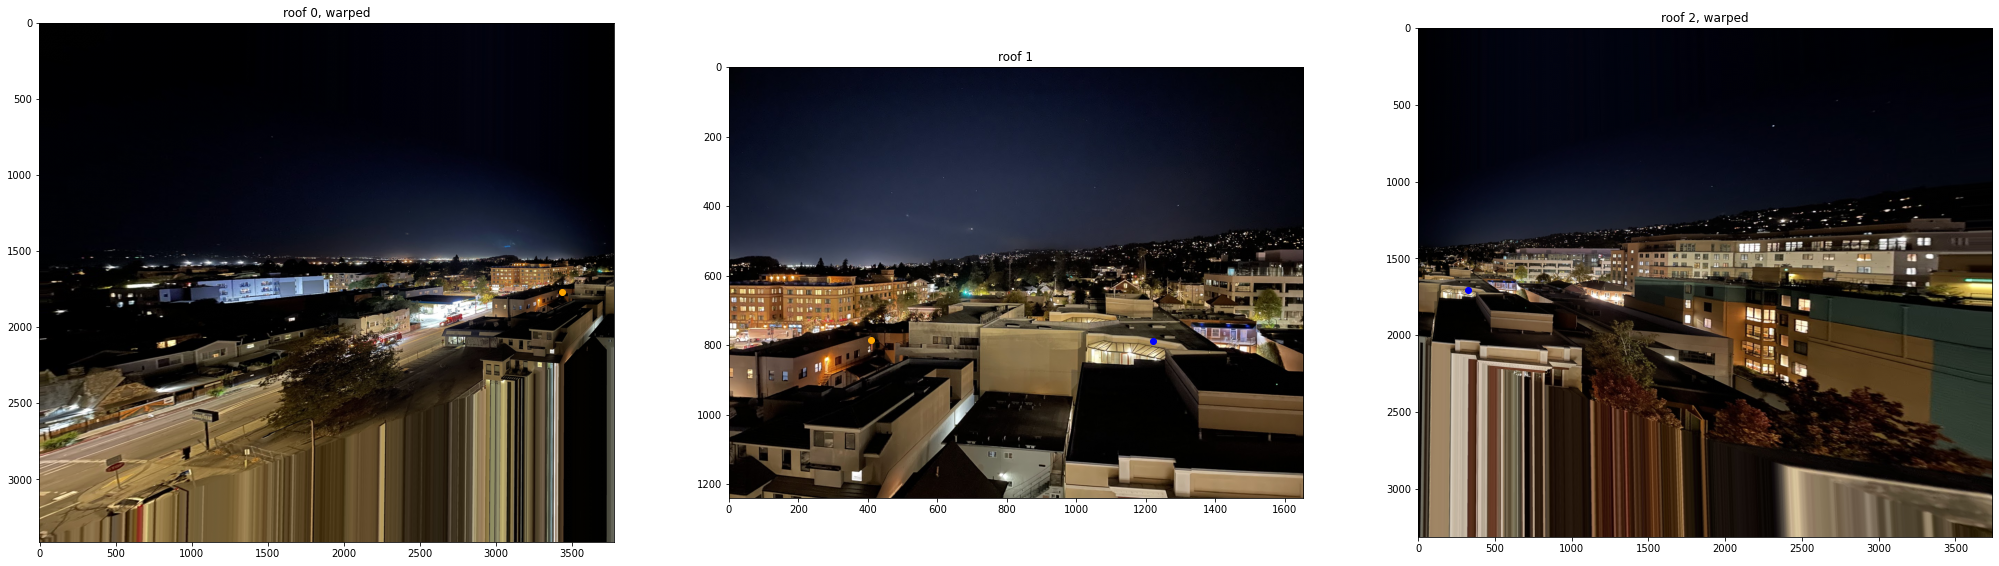

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(35, 12))
subplots = fig.subplots(1, 3)
ax0, ax1, ax2 = subplots[0], subplots[1], subplots[2]

ax0.set_title('roof 0, warped')
ax1.set_title('roof 1')
ax2.set_title('roof 2, warped')

ax0.imshow(warped01)
ax1.imshow(roofpics[1])
ax2.imshow(warped21)

ax0.scatter(*point01, color = 'orange')
ax1.scatter(*point10, color = 'orange')
ax1.scatter(*point12, color = 'blue')
ax2.scatter(*point21, color = 'blue')

# Positioning the images

## Getting the total width and height of final image

We'll use point10 (the orange point in the middle image) as an anchor.

In [40]:
width_leftof_point10 = max(point01[0], point21[0] - (point12[0] - point10[0]))
width_rightof_point10 = max(warped01.shape[1] - point01[0], (warped21.shape[1] - point21[0]) + (point12[0] - point10[0]))
total_width = width_leftof_point10 + width_rightof_point10
total_width

7661

In [41]:
height_above_point10 = max(point01[1], point21[1] - (point12[1] - point10[1]))
height_below_point10 = max(warped01.shape[0] - point01[1], (warped21.shape[0] - point21[1]) + (point12[1] - point10[1]))
total_height = height_above_point10 + height_below_point10
print(total_height)

3411


## Pasting the 3 images in the correct position
again using point10 as an anchor.

In [42]:
point10_final_xy = np.array([width_leftof_point10, height_above_point10])
point12_final_xy = point10_final_xy + point12 - point10

In [43]:
positioned_img0 = np.zeros((total_height, total_width, 3))
positioned_img1 = np.zeros((total_height, total_width, 3))
positioned_img2 = np.zeros((total_height, total_width, 3))

topleft_0_xy = point10_final_xy - point01
botright_0_xy = topleft_0_xy + np.array([warped01.shape[1], warped01.shape[0]])

topleft_1_xy = point10_final_xy - point10
botright_1_xy = topleft_1_xy + np.array([roofpics[1].shape[1], roofpics[1].shape[0]])

topleft_2_xy = point12_final_xy - point21
botright_2_xy = topleft_2_xy + np.array([warped21.shape[1], warped21.shape[0]])

In [44]:
positioned_img0[topleft_0_xy[1]:botright_0_xy[1], topleft_0_xy[0]:botright_0_xy[0]] = warped01
positioned_img1[topleft_1_xy[1]:botright_1_xy[1], topleft_1_xy[0]:botright_1_xy[0]] = roofpics[1]
positioned_img2[topleft_2_xy[1]:botright_2_xy[1], topleft_2_xy[0]:botright_2_xy[0]] = warped21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


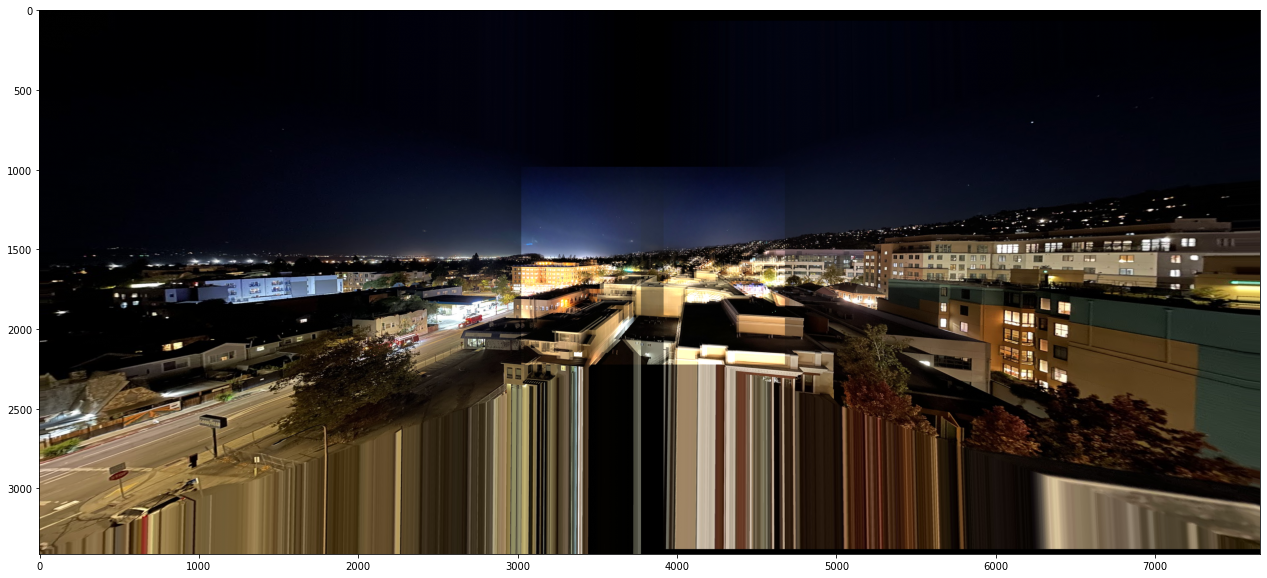

In [45]:
plt.figure(figsize=(35, 10))
plt.imshow(positioned_img0 + positioned_img1 + positioned_img2)

## Seperate low and high frequencies

In [46]:
import time

In [47]:
from scipy.ndimage import gaussian_filter

In [48]:
def color_gaussian(color_image, sigma):
    r, g, b = color_image[:,:,0], color_image[:,:,1], color_image[:,:,2]
    out = []
    for color in (r, g, b):
        start = time.time()
        out.append(gaussian_filter(color, sigma=sigma))
        print(f"one color took {time.time() - start}")
    return np.stack(out, axis = 2)

In [49]:
positioned_img0_b, positioned_img1_b, positioned_img2_b = [color_gaussian(img, sigma=20) for img in [positioned_img0, positioned_img1, positioned_img2]]

one color took 3.895714521408081
one color took 3.8736255168914795
one color took 3.848708391189575
one color took 4.079085350036621
one color took 4.026265621185303
one color took 3.9916255474090576
one color took 3.8947482109069824
one color took 3.8624136447906494
one color took 3.8259010314941406


In [50]:
positioned_img0_s = positioned_img0 - positioned_img0_b
positioned_img1_s = positioned_img1 - positioned_img1_b
positioned_img2_s = positioned_img2 - positioned_img2_b

## Blend using weighted averaging for low freq, hard border for high freq

In [51]:
def get_alpha(shape, start, end):
    width = shape[1]
    slope = 1./(end - start)
    row = np.zeros(width).astype(float)
    row[start:end] = np.linspace(0, 1, end - start)
    row[end:] = 1
    
    two_d = np.vstack([row]*shape[0])
    
    return np.stack([two_d, two_d, two_d], axis = 2)

In [52]:
alpha_01_b = get_alpha([total_height, total_width], topleft_1_xy[0], botright_0_xy[0])
alpha_12_b = get_alpha([total_height, total_width], topleft_2_xy[0], botright_1_xy[0])
alpha_01_s = get_alpha([total_height, total_width], point10_final_xy[0], point10_final_xy[0]+1)
alpha_12_s = get_alpha([total_height, total_width], point12_final_xy[0], point12_final_xy[0] + 1)

In [53]:
blended_roof_blurs = (positioned_img0_b * (1 - alpha_01_b) + \
                     positioned_img1_b * alpha_01_b * (1 - alpha_12_b) + \
                     positioned_img2_b * alpha_12_b)

In [54]:
blended_roof_sharps = (positioned_img0_s * (1 - alpha_01_s) + \
                     positioned_img1_s * alpha_01_s * (1 - alpha_12_s) + \
                     positioned_img2_s * alpha_12_s)

In [55]:
combined_roof = blended_roof_blurs + blended_roof_sharps
combined_roof = np.clip(combined_roof, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


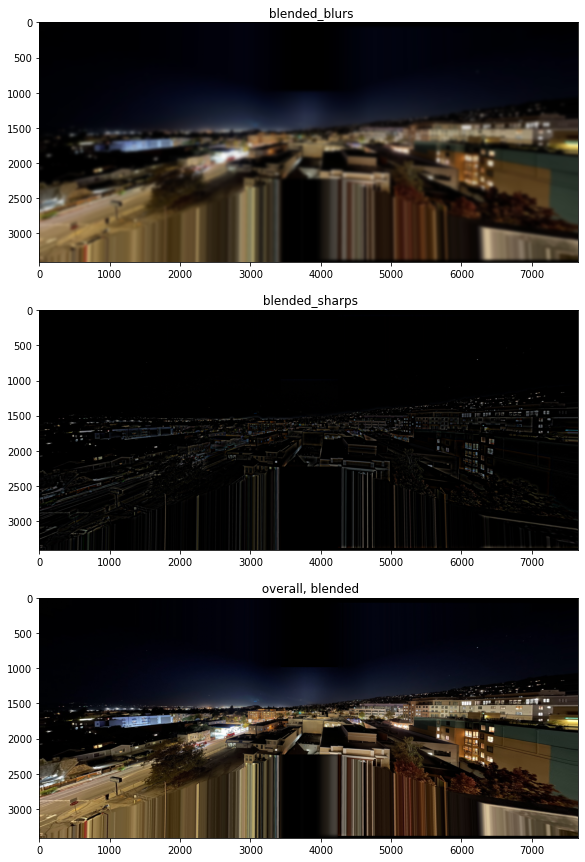

In [60]:
display_dictionary_of_images({'blended_blurs': blended_roof_blurs, 'blended_sharps': blended_roof_sharps, 'overall, blended':combined_roof}, w = 15, h = 5)

In [57]:
skio.imsave(f"data/roof_combined.jpg", combined_roof*255)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
